In [5]:
%load_ext autoreload
%autoreload 2
from dolfinx import fem, mesh, plot
from dolfinx.io import gmshio
from mpi4py import MPI
import ufl
from petsc4py import PETSc
from slepc4py import SLEPc
import numpy as np
from dolfinx.io import XDMFFile
import matplotlib.pyplot as plt
from scipy.linalg import null_space
from dolfinx_utils import *
from helmholtz_x.passive_flame_x import *
from helmholtz_x.eigensolvers_x import eps_solver
from helmholtz_x.eigenvectors_x import normalize_eigenvector, normalize_unit
from helmholtz_x.dolfinx_utils import XDMFReader, xdmf_writer 

%autoreload utils.dolfin_utils

In [14]:
def find_eigenvalue(epsilon):
    N = 100
    degree = 1
    c_const = 1
    msh = mesh.create_rectangle(MPI.COMM_WORLD, [[0, -epsilon], [1, 1]], [N, N])
    c = fem.Constant(msh, PETSc.ScalarType(c_const))

    boundaries = [(1, lambda x: np.isclose(x[0], 0)),
              (2, lambda x: np.isclose(x[0], 1)),
              (3, lambda x: np.isclose(x[1], -epsilon)),
              (4, lambda x: np.isclose(x[1], 1))]
    
    ds, facet_tags = tag_boundaries(msh, boundaries=boundaries, return_tags=True)

    boundary_conditions = {4: {'Dirichlet'},
                        3: {'Dirichlet'},
                        2: {'Dirichlet'},
                        1: {'Dirichlet'}}

    matrices = PassiveFlame(msh, facet_tags, boundary_conditions, c , degree = degree)

    matrices.assemble_A()
    matrices.assemble_C()

    A = matrices.A
    C = matrices.C

    target =  c_const * np.pi
    E = eps_solver(A, C, target**2, nev = 2)
    omega, p = normalize_eigenvector(msh, E, 0, degree=degree, which='right')

    xdmf_writer("Results/p", msh, p)

    p_normalized = normalize_unit(p)
    xdmf_writer("Results/p_normalized", msh, p_normalized)

    p = normalize_magnitude(p)

    return [omega, p, msh, ds]

In [11]:
def find_shapegrad_dirichlet(omega, p, msh, ds):
    V = fem.FunctionSpace(msh, ("Lagrange", 1))
    V2 = fem.VectorFunctionSpace(msh, ("Lagrange", 1))
    w = ufl.TrialFunction(V2)
    v = ufl.TestFunction(V2)

    a = ufl.inner(w, v)*ufl.dx
    L = ufl.inner(ufl.grad(p), v)*ufl.dx

    problem = fem.petsc.LinearProblem(a, L, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    grad_p = problem.solve()

    G = fem.Function(V)
    expr = fem.Expression(2/omega.real*np.dot(grad_p, [0, -1])**2, V.element.interpolation_points())
    G.interpolate(expr)
    dw = fem.assemble_scalar(fem.form(-G*ds(3))).real

    return dw

In [12]:
def find_shapegrad_dirichlet(omega, p, msh, ds):
    dp_dn = ufl.Dn(p)
    G = 2/omega.real*dp_dn**2
    C = -1
    dw = fem.assemble_scalar(fem.form(C* G*ds(3)))

    return dw

\/ Speed of sound function is used for passive flame matrices.
- Passive matrices are assembling..
- Matrix A is assembled.
- Matrix C is assembled.

- EPS solver started.
- EPS solver converged. Eigenvalue computed.
Eigenvalue-> 4.443431+0.000000j

Frequency -> 0.707194 (1/s) | Growth Rate -> 0.000000 (rad/s) 

(-1.7655671410415672e-16+1.2872218240675164e-16j)
\/ Speed of sound function is used for passive flame matrices.
- Passive matrices are assembling..
- Matrix A is assembled.
- Matrix C is assembled.

- EPS solver started.
- EPS solver converged. Eigenvalue computed.
Eigenvalue-> 4.443431+0.000000j

Frequency -> 0.707194 (1/s) | Growth Rate -> 0.000000 (rad/s) 

(-1.7655671410415672e-16+1.2872218240675164e-16j)
\/ Speed of sound function is used for passive flame matrices.
- Passive matrices are assembling..
- Matrix A is assembled.
- Matrix C is assembled.

- EPS solver started.
- EPS solver converged. Eigenvalue computed.
Eigenvalue-> 4.421489+0.000000j

Frequency -> 0.703702 

Text(0, 0.5, '$|\\delta_{FD} - \\delta_{AD}|$')

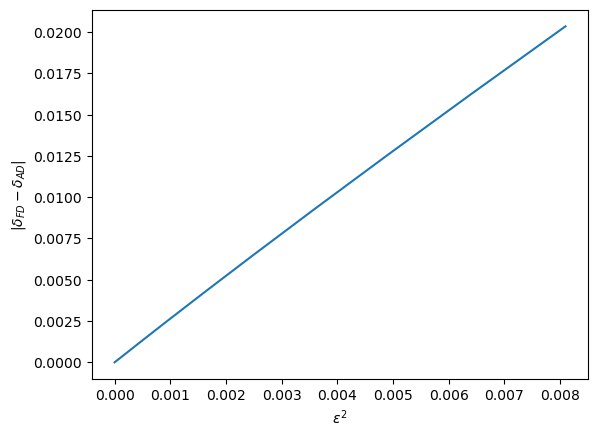

In [15]:
omega, p, msh, ds = find_eigenvalue(0)
dw = find_shapegrad_dirichlet(omega, p, msh, ds)
x_points = []
y_points = []

for i in range(10):
    epsilon = 0.01*i
    omega_new = find_eigenvalue(epsilon)[0]
    Delta_w_FD = omega_new.real - omega.real
    x_points.append(epsilon**2)
    y_points.append(abs(Delta_w_FD - dw*epsilon))

plt.plot(x_points, y_points)
plt.xlabel('$\epsilon^2$')
plt.ylabel('$|\delta_{FD} - \delta_{AD}|$')